In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("Train.csv", sep=",", low_memory=False)

In [3]:
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [4]:
data.shape

(10999, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [6]:
data.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [7]:
data.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
10994    False
10995    False
10996    False
10997    False
10998    False
Length: 10999, dtype: bool

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,10999.0,5500.000000,3175.282140,1.0,2750.5,5500.0,8249.5,10999.0
Customer_care_calls,10999.0,4.054459,1.141490,2.0,3.0,4.0,5.0,7.0
Customer_rating,10999.0,2.990545,1.413603,1.0,2.0,3.0,4.0,5.0
Cost_of_the_Product,10999.0,210.196836,48.063272,96.0,169.0,214.0,251.0,310.0
Prior_purchases,10999.0,3.567597,1.522860,2.0,3.0,3.0,4.0,10.0
Discount_offered,10999.0,13.373216,16.205527,1.0,4.0,7.0,10.0,65.0
Weight_in_gms,10999.0,3634.016729,1635.377251,1001.0,1839.5,4149.0,5050.0,7846.0
Reached.on.Time_Y.N,10999.0,0.596691,0.490584,0.0,0.0,1.0,1.0,1.0


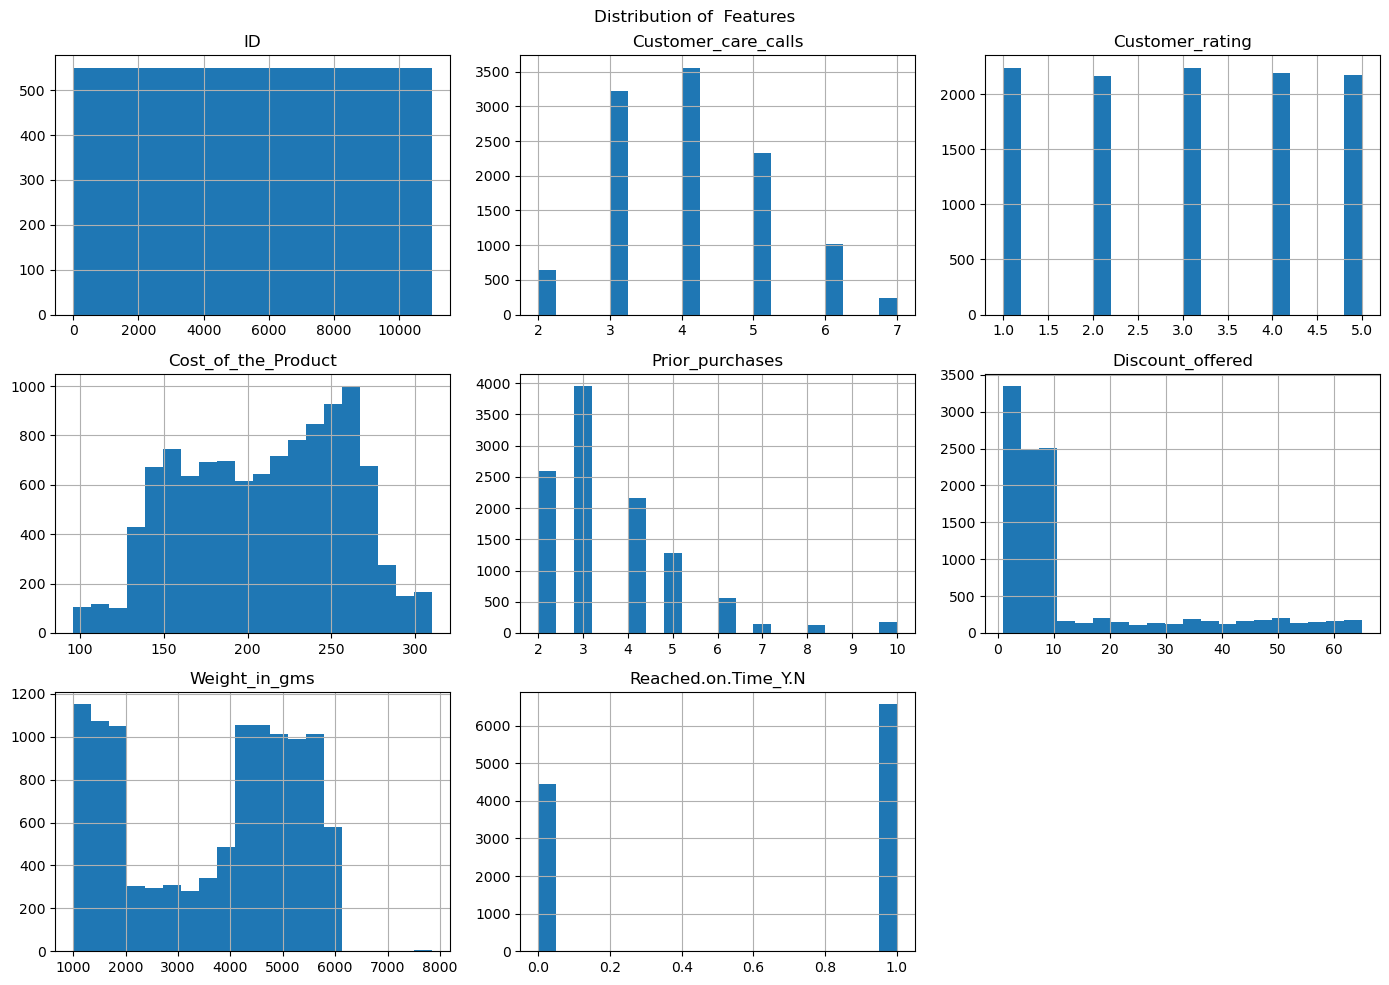

In [10]:
data.hist(figsize=(14, 10), bins=20)
plt.suptitle('Distribution of  Features')
plt.tight_layout()
plt.show()

In [13]:
!pip install mlxtend
!pip install networkx

In [15]:
from mlxtend.preprocessing import TransactionEncoder  
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import networkx as nx  
import matplotlib.pyplot as plt  

# Optional: set figure size
plt.rcParams['figure.figsize'] = (10, 6)


In [19]:
# Cell 3: helper binning functions (corrected to use 'data')
def bin_discount(x):
    if x == 0:
        return "Discount:None"
    elif x <= 10:
        return "Discount:Low"
    elif x <= 30:
        return "Discount:Medium"
    else:
        return "Discount:High"

def bin_weight(x):
    if x <= 200:
        return "Weight:<=200g"
    elif x <= 500:
        return "Weight:201-500g"
    elif x <= 1000:
        return "Weight:501-1000g"
    else:
        return "Weight:>1000g"

def bin_cost(x):
    # use quartiles for cost, computed from 'data'
    q1, q2, q3 = data['Cost_of_the_Product'].quantile([0.25, 0.5, 0.75])
    if x <= q1:
        return "Cost:Low"
    elif x <= q2:
        return "Cost:MedLow"
    elif x <= q3:
        return "Cost:MedHigh"
    else:
        return "Cost:High"

def bin_prior(x):
    if x == 0:
        return "Prior:0"
    elif x <= 2:
        return "Prior:1-2"
    elif x <= 5:
        return "Prior:3-5"
    else:
        return "Prior:6+"

def bin_calls(x):
    if x == 0:
        return "Calls:0"
    elif x <= 2:
        return "Calls:1-2"
    else:
        return "Calls:3+"


In [20]:
# Cell 4: transform each row into a list of item labels (transactions)
transactions = []

for _, row in data.iterrows():
    items = []
    items.append(f"Warehouse:{row['Warehouse_block']}")
    items.append(f"Shipment:{row['Mode_of_Shipment']}")
    items.append(f"Importance:{row['Product_importance']}")
    items.append(f"Gender:{row['Gender']}")
    items.append(f"Rating:{int(row['Customer_rating'])}star")
    items.append(bin_discount(int(row['Discount_offered'])))
    items.append(bin_weight(int(row['Weight_in_gms'])))
    items.append(bin_cost(float(row['Cost_of_the_Product'])))
    items.append(bin_prior(int(row['Prior_purchases'])))
    items.append(bin_calls(int(row['Customer_care_calls'])))
    items.append("Reached:Yes" if int(row['Reached.on.Time_Y.N']) == 1 else "Reached:No")
    transactions.append(list(set(items)))

print("Number of transactions:", len(transactions))
print("Example transaction:", transactions[0])


Number of transactions: 10999
Example transaction: ['Prior:3-5', 'Warehouse:D', 'Shipment:Flight', 'Gender:F', 'Calls:3+', 'Rating:2star', 'Importance:low', 'Reached:Yes', 'Weight:>1000g', 'Cost:MedLow', 'Discount:High']


In [21]:
# Cell 5: Transaction encoding (one-hot) ready for mlxtend apriori / fpgrowth
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit_transform(transactions)   # one-hot encoded boolean array
df_trans = pd.DataFrame(te_ary, columns=te.columns_).astype(bool)

print("Shape of transaction matrix:", df_trans.shape)
df_trans.head()


Shape of transaction matrix: (10999, 33)


,Calls:1-2,Calls:3+,Cost:High,Cost:Low,Cost:MedHigh,Cost:MedLow,Discount:High,Discount:Low,Discount:Medium,Gender:F,...,Reached:Yes,Shipment:Flight,Shipment:Road,Shipment:Ship,Warehouse:A,Warehouse:B,Warehouse:C,Warehouse:D,Warehouse:F,Weight:>1000g
0,False,True,False,False,False,True,True,False,False,True,...,True,True,False,False,False,False,False,True,False,True
1,False,True,False,False,True,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,True
2,True,False,False,False,False,True,True,False,False,False,...,True,True,False,False,True,False,False,False,False,True
3,False,True,False,False,False,True,False,True,False,False,...,True,True,False,False,False,True,False,False,False,True
4,True,False,False,False,False,True,True,False,False,True,...,True,True,False,False,False,False,True,False,False,True


In [22]:
# Cell 6: Frequent itemsets - run Apriori and FP-Growth
# adjust min_support as needed (here 0.01 = items present in >=1% of transactions)
min_support = 0.01

freq_apriori = apriori(df_trans, min_support=min_support, use_colnames=True)
freq_fp = fpgrowth(df_trans, min_support=min_support, use_colnames=True)

# Add a length column for convenience
freq_apriori['length'] = freq_apriori['itemsets'].apply(len)
freq_fp['length'] = freq_fp['itemsets'].apply(len)

print("Apriori frequent itemsets:", freq_apriori.shape)
print("FP-growth frequent itemsets:", freq_fp.shape)

# show top few
freq_apriori.sort_values(by='support', ascending=False).head(10)


Apriori frequent itemsets: (36673, 3)
FP-growth frequent itemsets: (36673, 3)


,support,itemsets,length
32,1.000000,(Weight:>1000g),1
1,0.941995,(Calls:3+),1
84,0.941995,"(Calls:3+, Weight:>1000g)",2
239,0.759342,"(Weight:>1000g, Discount:Low)",2
7,0.759342,(Discount:Low),1
59,0.721793,"(Calls:3+, Discount:Low)",2
722,0.721793,"(Calls:3+, Weight:>1000g, Discount:Low)",3
26,0.678425,(Shipment:Ship),1
500,0.678425,"(Shipment:Ship, Weight:>1000g)",2
393,0.672516,"(Prior:3-5, Weight:>1000g)",2


In [23]:
# Cell 7: Generate association rules for both methods
# We'll extract rules using 'confidence' and then show support, confidence, lift
min_confidence = 0.5

rules_apriori = association_rules(freq_apriori, metric="confidence", min_threshold=min_confidence)
rules_fp = association_rules(freq_fp, metric="confidence", min_threshold=min_confidence)

# sort by lift for highest-value rules
rules_apriori = rules_apriori.sort_values(['lift', 'confidence'], ascending=False).reset_index(drop=True)
rules_fp = rules_fp.sort_values(['lift', 'confidence'], ascending=False).reset_index(drop=True)

print("Apriori rules:", len(rules_apriori))
print("FP-Growth rules:", len(rules_fp))

# show the first few rules
rules_apriori[['antecedents','consequents','support','confidence','lift']].head(10)


Apriori rules: 198669
FP-Growth rules: 198669


,antecedents,consequents,support,confidence,lift
0,"(Calls:1-2, Gender:F, Reached:Yes)",(Cost:Low),0.010274,0.513636,2.053612
1,"(Calls:1-2, Weight:>1000g, Gender:F, Reached:Yes)",(Cost:Low),0.010274,0.513636,2.053612
2,"(Calls:1-2, Gender:F, Reached:Yes)","(Weight:>1000g, Cost:Low)",0.010274,0.513636,2.053612
3,"(Prior:3-5, Calls:1-2, Reached:Yes)",(Cost:Low),0.013092,0.510638,2.041625
4,"(Prior:3-5, Calls:1-2, Weight:>1000g, Reached:...",(Cost:Low),0.013092,0.510638,2.041625
5,"(Prior:3-5, Calls:1-2, Reached:Yes)","(Weight:>1000g, Cost:Low)",0.013092,0.510638,2.041625
6,"(Prior:3-5, Calls:1-2, Gender:F)",(Cost:Low),0.010092,0.509174,2.035772
7,"(Prior:3-5, Calls:1-2, Weight:>1000g, Gender:F)",(Cost:Low),0.010092,0.509174,2.035772
8,"(Prior:3-5, Calls:1-2, Gender:F)","(Weight:>1000g, Cost:Low)",0.010092,0.509174,2.035772
9,"(Calls:3+, Cost:MedLow, Discount:High, Importa...","(Gender:F, Reached:Yes)",0.010728,0.572816,1.911529


In [24]:
# Cell 8: Make rules human-readable (string columns) for pivoting & plotting
def frozenset_to_str(fs):
    return ', '.join(sorted(list(fs)))

for rules in (rules_apriori, rules_fp):
    rules['antecedent_str'] = rules['antecedents'].apply(frozenset_to_str)
    rules['consequent_str'] = rules['consequents'].apply(frozenset_to_str)


In [25]:
# Cell 9: Build evaluation matrices (pivot tables) for top-N rules & heatmaps
top_n = 25   # top N rules to visualize (by lift)
top_rules = rules_apriori.head(top_n)   # choose apriori rules for example

# pivot: antecedent rows x consequent cols -> confidence values
pivot_conf = top_rules.pivot(index='antecedent_str', columns='consequent_str', values='confidence').fillna(0)
pivot_lift = top_rules.pivot(index='antecedent_str', columns='consequent_str', values='lift').fillna(0)
pivot_support = top_rules.pivot(index='antecedent_str', columns='consequent_str', values='support').fillna(0)

# show shapes
print("Pivot (confidence) shape:", pivot_conf.shape)


Pivot (confidence) shape: (15, 6)


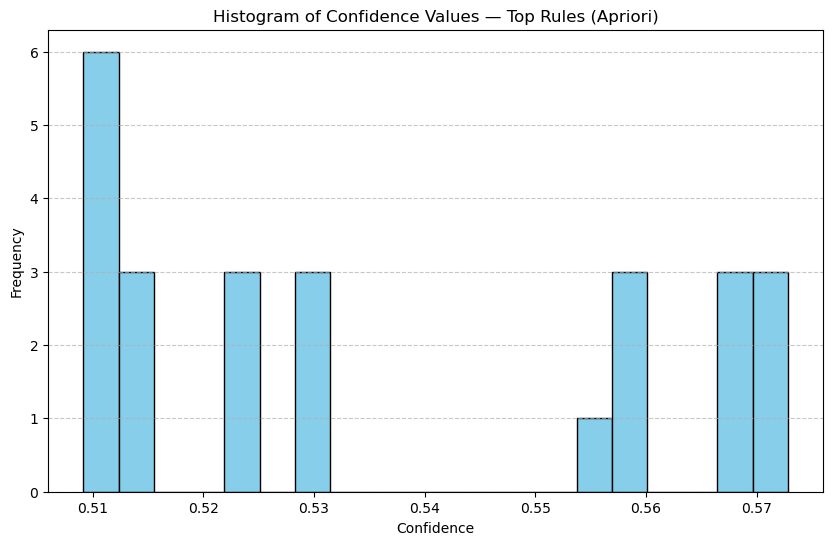

In [30]:
# Cell 10 (histogram alternative): Histogram of confidence values (from matrix)
plt.figure(figsize=(10,6))

# flatten pivot_conf values (remove NaNs/zeros if needed)
conf_values = pivot_conf.values.flatten()
conf_values = conf_values[conf_values > 0]   # keep only nonzero confidences

plt.hist(conf_values, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Confidence Values — Top Rules (Apriori)")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


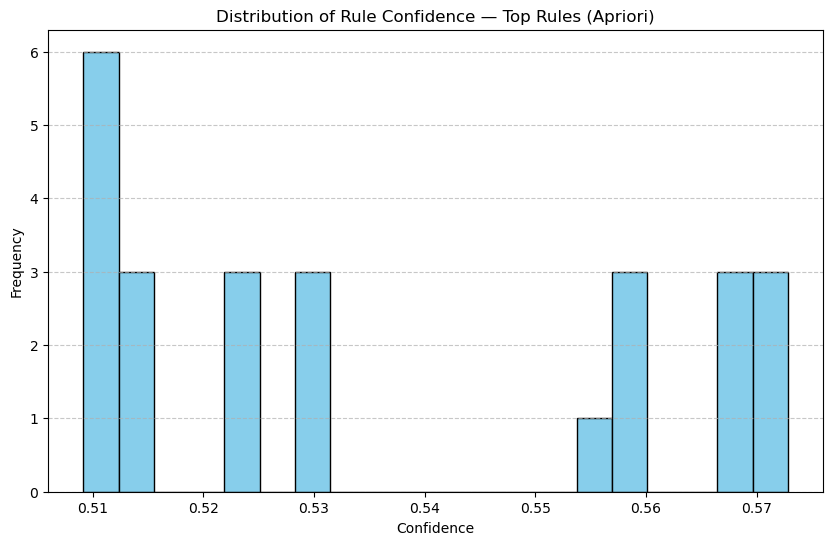

In [28]:
# Cell 10 (alternative): Histogram of confidence values from rules
plt.figure(figsize=(10,6))
plt.hist(top_rules['confidence'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Rule Confidence — Top Rules (Apriori)")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


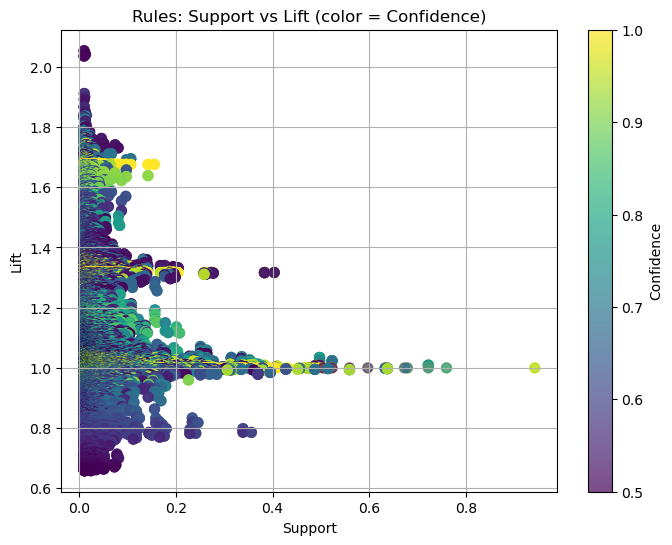

In [33]:
plt.figure(figsize=(8,6))
sc = plt.scatter(rules_plot['support'], rules_plot['lift'],
                 c=rules_plot['confidence'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar(sc, label="Confidence")
plt.xlabel("Support")
plt.ylabel("Lift")
plt.title("Rules: Support vs Lift (color = Confidence)")
plt.grid(True)
plt.show()


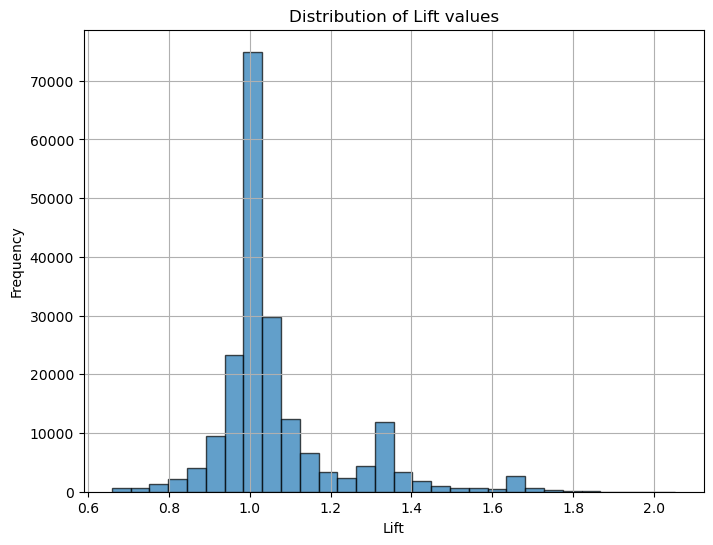

In [34]:
plt.figure(figsize=(8,6))
plt.hist(rules_plot['lift'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Lift")
plt.ylabel("Frequency")
plt.title("Distribution of Lift values")
plt.grid(True)
plt.show()


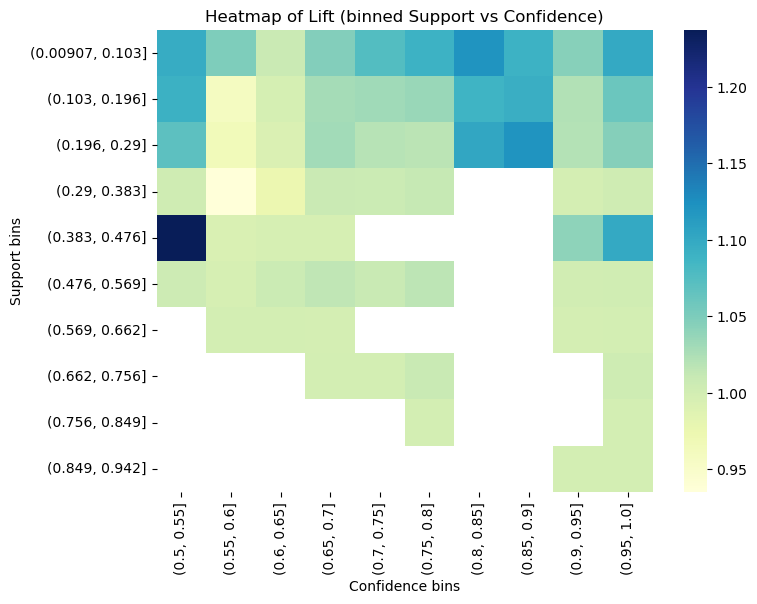

In [35]:

plt.figure(figsize=(8,6))
heatmap_data = rules_plot.pivot_table(values='lift', 
                                      index=pd.cut(rules_plot['support'], 10),
                                      columns=pd.cut(rules_plot['confidence'], 10),
                                      aggfunc='mean')
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False)
plt.title("Heatmap of Lift (binned Support vs Confidence)")
plt.xlabel("Confidence bins")
plt.ylabel("Support bins")
plt.show()


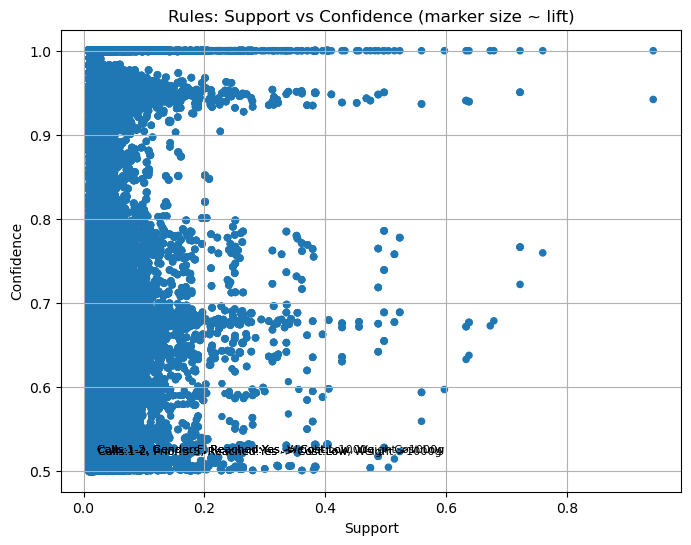

In [36]:
# Cell 12: Scatter plot: support vs confidence, size ~ lift
# use all rules or a subset
rules_plot = rules_apriori.copy()
plt.figure(figsize=(8,6))
plt.scatter(rules_plot['support'], rules_plot['confidence'], s=(rules_plot['lift']*20))
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Rules: Support vs Confidence (marker size ~ lift)")
# annotate top 5 by lift
top5 = rules_plot.sort_values('lift', ascending=False).head(5)
for _, r in top5.iterrows():
    plt.annotate(f"{frozenset_to_str(r['antecedents'])} -> {frozenset_to_str(r['consequents'])}",
                 (r['support'], r['confidence']),
                 textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)
plt.grid(True)
plt.show()


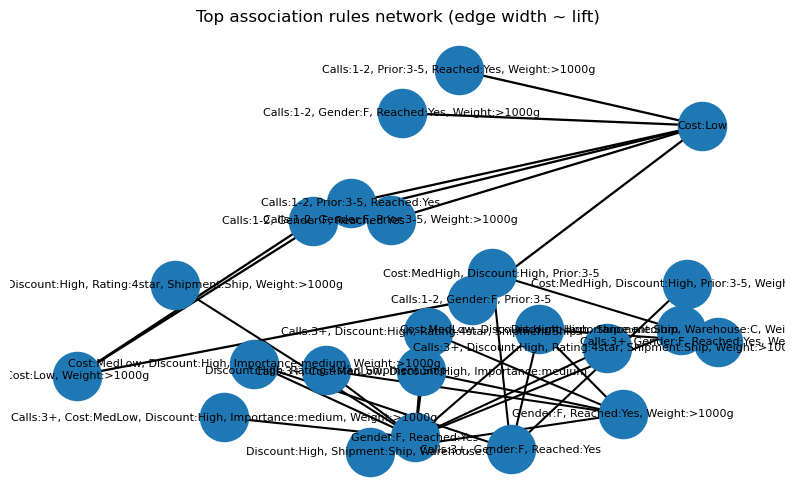

In [37]:
# Cell 13: Network graph of top rules (directed edges antecedent -> consequent, weighted by lift)
G = nx.DiGraph()

# take top_k rules by lift to avoid clutter
top_k = 30
for _, r in rules_apriori.sort_values('lift', ascending=False).head(top_k).iterrows():
    a = frozenset_to_str(r['antecedents'])
    c = frozenset_to_str(r['consequents'])
    weight = float(r['lift'])
    G.add_node(a)
    G.add_node(c)
    # add edge with attributes
    G.add_edge(a, c, weight=weight, confidence=float(r['confidence']), support=float(r['support']))

# draw
pos = nx.spring_layout(G, k=1.0, seed=42)
edge_weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw_networkx_nodes(G, pos, node_size=1200)
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=12, width=[w*0.8 for w in edge_weights])
plt.title("Top association rules network (edge width ~ lift)")
plt.axis('off')
plt.show()


In [38]:
# Cell 14: Compare Apriori vs FP-Growth outputs (example: top itemsets and top rules overlap)
# frequent itemsets overlap (by set)
set_ap = set(freq_apriori['itemsets'].apply(lambda s: tuple(sorted(list(s)))))
set_fp = set(freq_fp['itemsets'].apply(lambda s: tuple(sorted(list(s)))))
common_itemsets = set_ap.intersection(set_fp)
print("Total apriori itemsets:", len(set_ap))
print("Total fpgrowth itemsets:", len(set_fp))
print("Common itemsets:", len(common_itemsets))

# rules overlap by identical antecedent+consequent
def rule_signature(r):
    return (tuple(sorted(list(r['antecedents']))), tuple(sorted(list(r['consequents']))))

sig_ap = set(rules_apriori.apply(rule_signature, axis=1))
sig_fp = set(rules_fp.apply(rule_signature, axis=1))
print("Apriori rules:", len(sig_ap))
print("FP rules:", len(sig_fp))
print("Common rules:", len(sig_ap.intersection(sig_fp)))


Total apriori itemsets: 36673
Total fpgrowth itemsets: 36673
Common itemsets: 36673
Apriori rules: 198669
FP rules: 198669
Common rules: 198669


In [39]:
# Cell 15: Save results to CSV for inspection (optional)
rules_apriori.to_csv("rules_apriori.csv", index=False)
rules_fp.to_csv("rules_fpgrowth.csv", index=False)
freq_apriori.sort_values('support', ascending=False).to_csv("freq_itemsets_apriori.csv", index=False)
freq_fp.sort_values('support', ascending=False).to_csv("freq_itemsets_fpgrowth.csv", index=False)
print("Saved CSVs: rules_apriori.csv, rules_fpgrowth.csv, freq_itemsets_*.csv")

Saved CSVs: rules_apriori.csv, rules_fpgrowth.csv, freq_itemsets_*.csv


In [40]:


# Drop unwanted columns
X = data.drop(["ID", "Reached.on.Time_Y.N"], axis=1)

print("Shape after dropping:", X.shape)
print("Remaining columns:", X.columns.tolist())


Shape after dropping: (10999, 10)
Remaining columns: ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms']


In [53]:
# Select customer-related features
X_cust = data[[
    
    "Customer_rating",
    "Cost_of_the_Product",
    "Prior_purchases",
    "Discount_offered",
    "Weight_in_gms"
]]
print("Customer feature shape:", X_cust.shape)
print("Features:", X_cust.columns.tolist())


Customer feature shape: (10999, 5)
Features: ['Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']


In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cust)


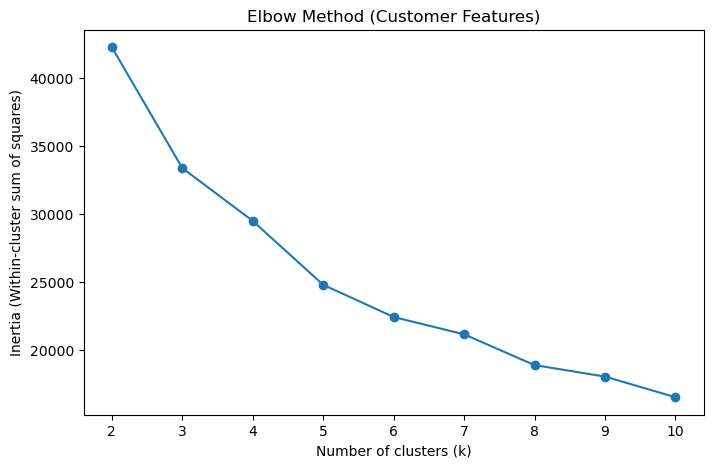

In [55]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 11)  # test between 2 and 10 clusters

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-cluster sum of squares)")
plt.title("Elbow Method (Customer Features)")
plt.show()


C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

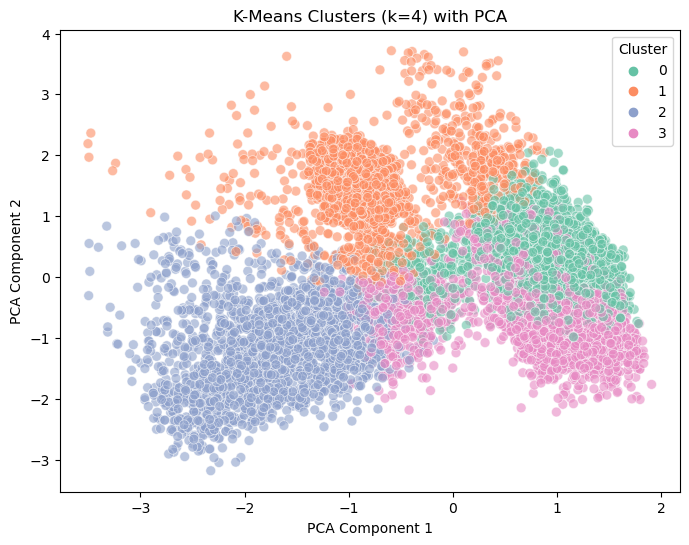

                  ID  Customer_care_calls  Customer_rating  \
Cluster                                                      
0        5918.012422             3.792369         3.012866   
1        7109.647204             5.222451         3.041941   
2        1565.984871             3.667675         2.963691   
3        6179.974596             3.712009         2.962356   

         Cost_of_the_Product  Prior_purchases  Discount_offered  \
Cluster                                                           
0                 200.867791         3.177906          7.178793   
1                 251.729852         5.129112          7.256990   
2                 189.419062         3.113969         43.670197   
3                 201.241109         3.101155          6.157968   

         Weight_in_gms  Reached.on.Time_Y.N  
Cluster                                      
0          4530.302130             0.532831  
1          2061.583470             0.512747  
2          2213.860313             1.000

In [65]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Select customer features
# -------------------------------
customer_features = data[[
                          'Customer_rating',
                          'Cost_of_the_Product',
                          'Prior_purchases',
                          'Discount_offered',
                          'Weight_in_gms']]

# -------------------------------
# 2. Scale features
# -------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_features)

# -------------------------------
# 3. Apply KMeans with k=4
# -------------------------------
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels back to dataset
data['Cluster'] = clusters

# -------------------------------
# 4. PCA for visualization (2D)
# -------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=clusters, palette="Set2", alpha=0.6, s=50)
plt.title("K-Means Clusters (k=4) with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# -------------------------------
# 5. Inspect clusters
# -------------------------------

print(cluster_summary)


In [66]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Silhouette Score
sil_score = silhouette_score(X_scaled, clusters)
print("Silhouette Score:", sil_score)

# Davies-Bouldin Index
dbi = davies_bouldin_score(X_scaled, clusters)
print("Davies-Bouldin Index:", dbi)

# Calinski-Harabasz Index
chi = calinski_harabasz_score(X_scaled, clusters)
print("Calinski-Harabasz Index:", chi)


Silhouette Score: 0.22952026052676158
Davies-Bouldin Index: 1.4712622876428525
Calinski-Harabasz Index: 3171.9054569483337


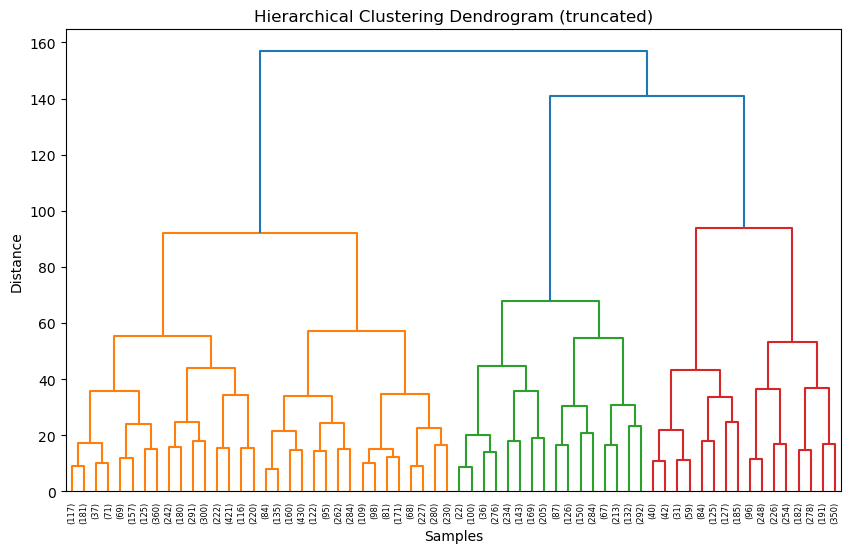

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

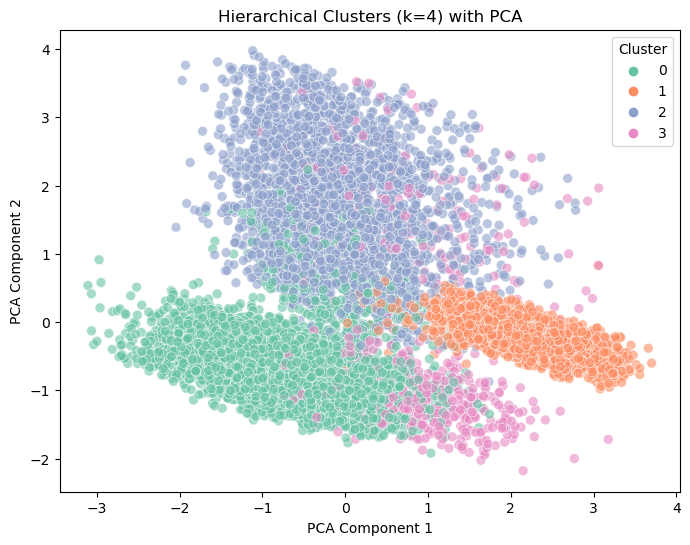

In [67]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Select and scale features
# -------------------------------
customer_features = data[['Customer_care_calls',
                          'Customer_rating',
                          'Cost_of_the_Product',
                          'Prior_purchases',
                          'Discount_offered',
                          'Weight_in_gms']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_features)

# -------------------------------
# 2. Dendrogram to find optimal clusters
# -------------------------------
plt.figure(figsize=(10,6))
linkage_matrix = linkage(X_scaled, method='ward')
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

# -------------------------------
# 3. Apply Agglomerative Clustering
# -------------------------------
hc = AgglomerativeClustering(n_clusters=4, linkage='ward')
hc_clusters = hc.fit_predict(X_scaled)

# Add to dataset
data['HC_Cluster'] = hc_clusters

# -------------------------------
# 4. PCA for visualization
# -------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=hc_clusters, palette="Set2", alpha=0.6, s=50)
plt.title("Hierarchical Clusters (k=4) with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


In [68]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [69]:
# Cell 2: ensure clean index and quick sanity print
data = data.reset_index(drop=True)
print("data.shape:", data.shape)
# show first rows to confirm columns present
data.head()


data.shape: (10999, 14)


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Cluster,HC_Cluster
0,1,D,Flight,4,2,177,3,low,F,44,1233,1,2,2
1,2,F,Flight,4,5,216,2,low,M,59,3088,1,2,2
2,3,A,Flight,2,2,183,4,low,M,48,3374,1,2,2
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1,1,2
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1,2,2


In [71]:
# Cell 3: choose which columns to use for content vectors
# Edit these lists if you want to include / exclude features
cat_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
num_cols = ['Cost_of_the_Product', 'Weight_in_gms']

# Columns to display in recommendation results (edit as desired)
display_cols = ['ID', 'Warehouse_block', 'Mode_of_Shipment',
                'Product_importance', 'Cost_of_the_Product',
                'Weight_in_gms', 'Customer_rating', 'Prior_purchases',
                'Reached.on.Time_Y.N']


In [72]:
# Cell 4: one-hot encode categorical + scale numeric features -> content_matrix
content_df = data[cat_cols + num_cols].copy()

# one-hot encode categoricals
content_encoded = pd.get_dummies(content_df, columns=cat_cols, drop_first=False)

# scale numeric columns so their range is comparable to one-hot features
num_scaler = StandardScaler()
content_encoded[num_cols] = num_scaler.fit_transform(content_encoded[num_cols])

# final numpy matrix used for similarity calculations
content_matrix = content_encoded.values
print("content_matrix shape:", content_matrix.shape)
# Optionally view few column names:
print("content feature columns (sample):", content_encoded.columns.tolist()[:20])


content_matrix shape: (10999, 15)
content feature columns (sample): ['Cost_of_the_Product', 'Weight_in_gms', 'Warehouse_block_A', 'Warehouse_block_B', 'Warehouse_block_C', 'Warehouse_block_D', 'Warehouse_block_F', 'Mode_of_Shipment_Flight', 'Mode_of_Shipment_Road', 'Mode_of_Shipment_Ship', 'Product_importance_high', 'Product_importance_low', 'Product_importance_medium', 'Gender_F', 'Gender_M']


In [73]:
# Cell 5: helper to compute similarity of a single item to all items (memory efficient)
def get_content_similarity(item_idx, matrix=content_matrix):
    """
    Return a 1D numpy array of cosine similarities between item_idx and every row in matrix.
    This computes only one similarity-row, avoiding storing the full NxN matrix.
    """
    if item_idx < 0 or item_idx >= matrix.shape[0]:
        raise IndexError("item_idx out of range")
    item_vec = matrix[item_idx].reshape(1, -1)
    sims = cosine_similarity(item_vec, matrix)[0]   # shape (n_items,)
    return sims

# NOTE: if you prefer to precompute full similarity matrix (fast queries, heavy memory),
# you could do: content_sim = cosine_similarity(content_matrix)
# but with 11k items that yields ~10999x10999 floats (~ ~1GB); only do if you have RAM.


In [74]:
# Cell 6: content-based recommender
def recommend_content(item_idx, top_n=10, show_cols=None):
    """
    Return top_n most content-similar items to data.loc[item_idx].
    - item_idx: integer index into data (0..len(data)-1)
    - show_cols: optional list of columns from `data` to return alongside similarity
    """
    sims = get_content_similarity(item_idx)
    sims[item_idx] = -1  # exclude the item itself
    top_idx = np.argsort(sims)[-top_n:][::-1]  # indices of top_n items
    results = data.loc[top_idx].copy().reset_index(drop=True)
    results['similarity'] = sims[top_idx]
    if show_cols is not None:
        cols = [c for c in (show_cols + ['similarity']) if c in results.columns]
        return results[cols]
    return results


In [75]:
# Cell 7: popularity score components & normalization (used by hybrid)
pop_cols = ['Customer_rating', 'Prior_purchases', 'Discount_offered']

# check existence
missing = [c for c in pop_cols if c not in data.columns]
if missing:
    raise KeyError(f"The following pop_cols are missing in `data`: {missing}")

# normalize each pop column to [0,1]
pop_scaler = MinMaxScaler()
pop_norm = pd.DataFrame(pop_scaler.fit_transform(data[pop_cols]), columns=pop_cols, index=data.index)

# default weights for popularity (editable)
default_pop_weights = np.array([0.6, 0.3, 0.1])  # rating, prior_purchases, discount

# compute a single normalized popularity score (0..1)
raw_pop_score = pop_norm.dot(default_pop_weights)
pop_score = (raw_pop_score - raw_pop_score.min()) / (raw_pop_score.max() - raw_pop_score.min())
pop_score = pd.Series(pop_score, index=data.index, name='pop_score')

# Quick check
pop_score.describe()


count    10999.000000
mean         0.379069
std          0.222547
min          0.000000
25%          0.193396
50%          0.378931
75%          0.567610
max          1.000000
Name: pop_score, dtype: float64

In [76]:
# Cell 8: hybrid recommender (alpha weight content vs popularity)
def recommend_hybrid(item_idx, top_n=10, alpha=0.7, pop_weights=None, show_cols=None):
    """
    Hybrid recommendations:
    combined_score = alpha * content_similarity + (1-alpha) * pop_score
    - pop_weights: optional weights to recompute pop_score from pop_cols (must match length)
    """
    # recompute popularity vector if custom weights provided
    if pop_weights is not None:
        w = np.array(pop_weights)
        tmp = pop_norm.dot(w)
        tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())
        pop_vec = tmp.values
    else:
        pop_vec = pop_score.values  # numpy array aligned with data.index

    # content similarity vector (item -> all items)
    content_sims = get_content_similarity(item_idx)  # shape (n_items,)
    combined = alpha * content_sims + (1.0 - alpha) * pop_vec
    combined[item_idx] = -1  # exclude itself

    top_idx = np.argsort(combined)[-top_n:][::-1]
    results = data.loc[top_idx].copy().reset_index(drop=True)
    results['hybrid_score'] = combined[top_idx]
    if show_cols is not None:
        cols = [c for c in (show_cols + ['hybrid_score']) if c in results.columns]
        return results[cols]
    return results


In [77]:
# Cell 9: test the recommenders on an example item
item_idx = 6    # change to any row index you want to query
top_n = 10

print("Query item (row):")
display(data.loc[[item_idx], display_cols])

print("\nContent-based recommendations:")
display(recommend_content(item_idx, top_n=top_n, show_cols=display_cols))

print("\nHybrid recommendations (alpha=0.7):")
display(recommend_hybrid(item_idx, top_n=top_n, alpha=0.7, show_cols=display_cols))


Query item (row):


,ID,Warehouse_block,Mode_of_Shipment,Product_importance,Cost_of_the_Product,Weight_in_gms,Customer_rating,Prior_purchases,Reached.on.Time_Y.N
6,7,D,Flight,low,250,2371,4,3,1



Content-based recommendations:


,ID,Warehouse_block,Mode_of_Shipment,Product_importance,Cost_of_the_Product,Weight_in_gms,Customer_rating,Prior_purchases,Reached.on.Time_Y.N,similarity
0,2203,D,Flight,low,266,2508,3,3,1,0.990559
1,7669,D,Flight,low,269,1667,3,5,1,0.981160
2,8905,D,Flight,low,270,1698,4,4,0,0.981157
3,10417,D,Flight,low,263,1511,2,6,1,0.979881
4,6043,D,Flight,low,271,1667,5,5,0,0.979573
5,2191,D,Flight,low,230,2890,5,2,1,0.975943
6,2617,D,Flight,low,258,3186,1,2,1,0.973533
7,7957,D,Flight,low,229,1857,5,6,0,0.972722
8,6577,D,Flight,low,260,1221,5,4,0,0.969119
9,1921,D,Flight,low,232,3128,5,2,1,0.968089



Hybrid recommendations (alpha=0.7):


,ID,Warehouse_block,Mode_of_Shipment,Product_importance,Cost_of_the_Product,Weight_in_gms,Customer_rating,Prior_purchases,Reached.on.Time_Y.N,hybrid_score
0,7957,D,Flight,low,229,1857,5,6,0,0.909679
1,6043,D,Flight,low,271,1667,5,5,0,0.902210
2,6577,D,Flight,low,260,1221,5,4,0,0.882629
3,2191,D,Flight,low,230,2890,5,2,1,0.881745
4,1921,D,Flight,low,232,3128,5,2,1,0.868228
5,8353,D,Flight,low,302,1592,5,4,0,0.863660
6,8905,D,Flight,low,270,1698,4,4,0,0.849545
7,6301,D,Flight,low,258,1051,4,4,1,0.831800
8,7411,D,Flight,low,290,1544,4,4,1,0.828392
9,9451,D,Flight,low,296,1033,4,4,0,0.818038


Query item (row):


,ID,Warehouse_block,Mode_of_Shipment,Product_importance,Cost_of_the_Product,Weight_in_gms,Customer_rating,Prior_purchases,Reached.on.Time_Y.N
0,1,D,Flight,low,177,1233,2,3,1



Content-based recommendations:


,ID,Warehouse_block,Mode_of_Shipment,Product_importance,Cost_of_the_Product,Weight_in_gms,Customer_rating,Prior_purchases,Reached.on.Time_Y.N,similarity
0,2749,D,Flight,low,178,1165,4,3,1,0.999864
1,1387,D,Flight,low,180,1414,1,3,1,0.999216
2,967,D,Flight,low,163,1470,5,4,1,0.992089
3,2473,D,Flight,low,156,1553,5,3,1,0.983231
4,283,D,Flight,low,155,1712,3,3,1,0.977862
5,10975,D,Flight,low,219,1505,2,5,0,0.938497
6,277,D,Flight,low,136,1962,2,3,1,0.935613
7,1099,D,Flight,low,181,2815,2,2,1,0.931237
8,6307,D,Flight,low,221,1630,3,5,1,0.930043
9,2875,D,Flight,low,193,2775,2,2,1,0.928528


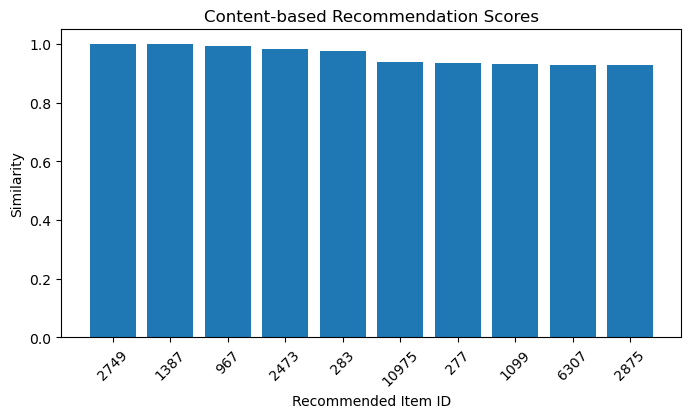


Hybrid recommendations (alpha=0.7):


,ID,Warehouse_block,Mode_of_Shipment,Product_importance,Cost_of_the_Product,Weight_in_gms,Customer_rating,Prior_purchases,Reached.on.Time_Y.N,hybrid_score
0,967,D,Flight,low,163,1470,5,4,1,0.920877
1,2473,D,Flight,low,156,1553,5,3,1,0.908544
2,7957,D,Flight,low,229,1857,5,6,0,0.855483
3,2749,D,Flight,low,178,1165,4,3,1,0.847074
4,1657,D,Flight,low,156,1308,5,6,1,0.847050
5,2947,D,Ship,low,144,1110,5,6,1,0.834953
6,1381,D,Flight,low,118,1726,5,2,1,0.819685
7,1105,D,Flight,low,188,3067,4,4,1,0.811514
8,547,D,Flight,high,147,1642,5,4,1,0.799644
9,283,D,Flight,low,155,1712,3,3,1,0.799598


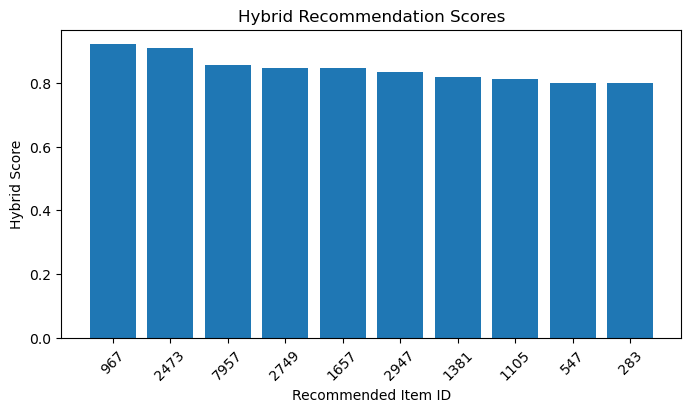

In [78]:
# Cell 9: test the recommenders on an example item + histogram visualization
import matplotlib.pyplot as plt

item_idx = 0    # change to any row index you want to query
top_n = 10

print("Query item (row):")
display(data.loc[[item_idx], display_cols])

# --- Content-based ---
content_recs = recommend_content(item_idx, top_n=top_n, show_cols=display_cols)

print("\nContent-based recommendations:")
display(content_recs)

# Histogram for content similarity
plt.figure(figsize=(8,4))
plt.bar(range(len(content_recs)), content_recs['similarity'], tick_label=content_recs['ID'])
plt.title("Content-based Recommendation Scores")
plt.xlabel("Recommended Item ID")
plt.ylabel("Similarity")
plt.xticks(rotation=45)
plt.show()

# --- Hybrid ---
hybrid_recs = recommend_hybrid(item_idx, top_n=top_n, alpha=0.7, show_cols=display_cols)

print("\nHybrid recommendations (alpha=0.7):")
display(hybrid_recs)

# Histogram for hybrid scores
plt.figure(figsize=(8,4))
plt.bar(range(len(hybrid_recs)), hybrid_recs['hybrid_score'], tick_label=hybrid_recs['ID'])
plt.title("Hybrid Recommendation Scores")
plt.xlabel("Recommended Item ID")
plt.ylabel("Hybrid Score")
plt.xticks(rotation=45)
plt.show()


In [79]:
# Cell 10: generate hybrid recommendations for multiple query items and save
query_indices = [0, 5, 10]   # change to any list of indices
all_recs = []
for q in query_indices:
    recs = recommend_hybrid(q, top_n=5, alpha=0.7)
    recs['query_idx'] = q
    all_recs.append(recs)
all_recs_df = pd.concat(all_recs, ignore_index=True)
all_recs_df.to_csv("hybrid_recommendations_sample.csv", index=False)
print("Saved sample recommendations to hybrid_recommendations_sample.csv")


Saved sample recommendations to hybrid_recommendations_sample.csv


In [81]:
from sklearn.preprocessing import LabelEncoder

df = data.copy()

# Encode categorical features
le = LabelEncoder()
df['Product_importance'] = le.fit_transform(df['Product_importance'])
df['Mode_of_Shipment'] = le.fit_transform(df['Mode_of_Shipment'])

# Select product-related features + ID
features = ['ID', 'Cost_of_the_Product', 'Weight_in_gms', 'Product_importance', 'Mode_of_Shipment']

In [82]:
from sklearn.ensemble import RandomForestRegressor

X = df[features]
y = df['Discount_offered']

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)

df['discount_pred'] = rf.predict(X)


In [83]:
df['discount_residual'] = abs(df['Discount_offered'] - df['discount_pred'])

# Set anomaly threshold (mean + 3*std rule)
threshold = df['discount_residual'].mean() + 3*df['discount_residual'].std()

df['discount_anomaly'] = (df['discount_residual'] > threshold).astype(int)

print("Anomalies detected:", df['discount_anomaly'].sum())


Anomalies detected: 224


In [84]:
suspicious = df[df['discount_anomaly'] == 1][['ID','Cost_of_the_Product','Weight_in_gms',
                                              'Product_importance','Mode_of_Shipment',
                                              'Discount_offered','discount_pred','discount_residual']]
print(suspicious.head(10))


      ID  Cost_of_the_Product  Weight_in_gms  Product_importance  \
6      7                  250           2371                   1   
33    34                  234           3261                   2   
38    39                  215           3905                   1   
71    72                  230           2229                   1   
98    99                  144           1104                   2   
110  111                  158           1284                   1   
118  119                  263           2947                   1   
150  151                  220           2551                   2   
187  188                  222           3778                   2   
206  207                  157           1477                   1   

     Mode_of_Shipment  Discount_offered  discount_pred  discount_residual  
6                   0                 3         16.975             13.975  
33                  2                 4         16.420             12.420  
38                  2  

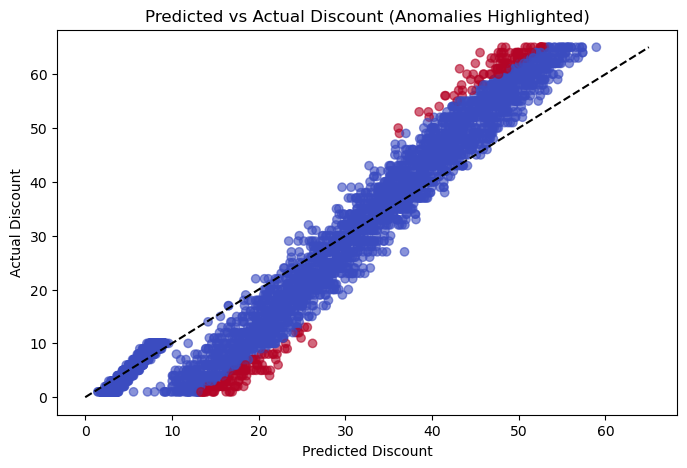

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(df['discount_pred'], df['Discount_offered'], 
            c=df['discount_anomaly'], cmap='coolwarm', alpha=0.6)
plt.plot([0, df['Discount_offered'].max()], [0, df['Discount_offered'].max()], 'k--')
plt.xlabel("Predicted Discount")
plt.ylabel("Actual Discount")
plt.title("Predicted vs Actual Discount (Anomalies Highlighted)")
plt.show()


In [86]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = data.copy()

# Encode categorical
le = LabelEncoder()
df['Product_importance'] = le.fit_transform(df['Product_importance'])
df['Mode_of_Shipment'] = le.fit_transform(df['Mode_of_Shipment'])

# Select product context features
X = df[['Cost_of_the_Product', 'Weight_in_gms', 'Product_importance', 'Mode_of_Shipment']]

# Scale for anomaly models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [87]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_iso'] = iso.fit_predict(X_scaled)

# Convert -1 → anomaly, 1 → normal
df['anomaly_iso'] = df['anomaly_iso'].map({1:0, -1:1})
print("Isolation Forest anomalies:", df['anomaly_iso'].sum())


Isolation Forest anomalies: 550


In [88]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred = lof.fit_predict(X_scaled)

df['anomaly_lof'] = (y_pred == -1).astype(int)
print("LOF anomalies:", df['anomaly_lof'].sum())


LOF anomalies: 550


In [89]:
suspicious = df[(df['anomaly_iso'] == 1) | (df['anomaly_lof'] == 1)][
    ['Cost_of_the_Product','Weight_in_gms','Product_importance','Mode_of_Shipment','Discount_offered']
]

print(suspicious.head(15))


     Cost_of_the_Product  Weight_in_gms  Product_importance  Mode_of_Shipment  \
3                    176           1177                   2                 0   
6                    250           2371                   1                 0   
13                   275           2602                   0                 0   
26                   172           1066                   0                 2   
36                   137           1477                   0                 2   
58                   141           1367                   0                 2   
83                   162           1364                   0                 2   
87                   278           2974                   2                 2   
90                   174           1085                   0                 2   
91                   286           3163                   1                 2   
114                  168           1616                   0                 1   
115                  176    

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


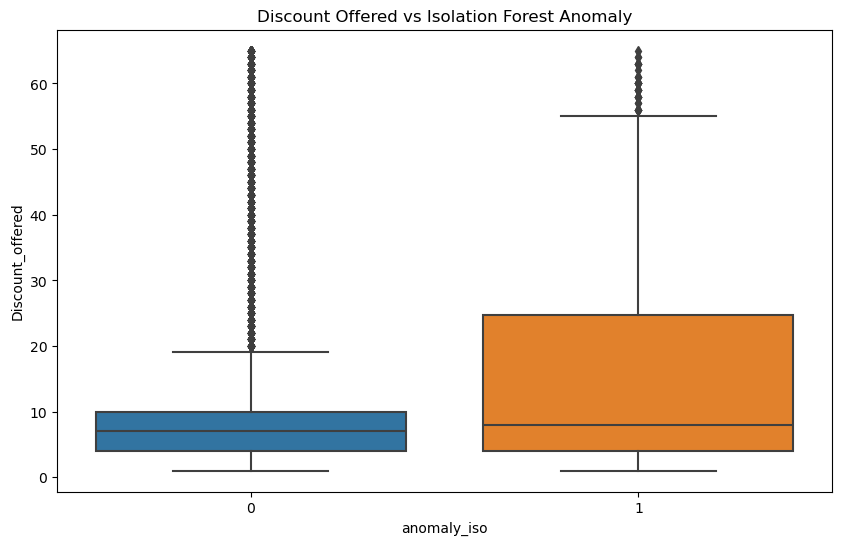

In [90]:

sns.boxplot(x='anomaly_iso', y='Discount_offered', data=df)
plt.title("Discount Offered vs Isolation Forest Anomaly")
plt.show()
